# Data Basics Pipeline

This example is going to draw upon all of the topics we have covered in this workshop series and see how they all fit together.

---

## Importing a CSV file into a table using sqlite3 tool
---
In the first scenario, you want to import data from CSV file into a table that does not exist in the SQLite database.

First, the sqlite3 tool creates the table. The sqlite3 tool uses the first row of the CSV file as the names of the columns of the table.
Second, the sqlite3 tool import data from the second row of the CSV file into the table.
We will import a CSV file named service_requests.csv

First, fire up sqlite3 in a terminal window:

Set the mode to CSV to instruct the command-line shell program to interpret the input file as a CSV file. To do this, you use the .mode command as follows:

Next, import the csv file as an sql table using the following:

To verify the import, you use the .schema command to display the structure of the requests table:

Save the table as a .db file using the .clone command:

Now we can use this file like we have all along! You can exit sqlite3 and it will still be in our directory to work with again later. 

## Working with python and pandas
---
Let's open up our database again and use pandas to extract some useful information.

In [ ]:
import sqlite3
import pandas as pd
%matplotlib inline

sqlite_file = 'service_requests.db'
conn = sqlite3.connect(sqlite_file)

query = '''
SELECT * from requests
LIMIT 5;
'''

df = pd.read_sql(query, conn)
df

In [ ]:
query = '''
SELECT * from codes
LIMIT 5;
'''

df = pd.read_sql(query, conn)
df

These tables can be joined on request_type = issue, so lets leverage that to reduce our dimensionality when trying to visualize the volume of request types for each neighborhood by grouping on category. First, using sqlite:

In [ ]:
query = '''
SELECT * from requests
JOIN codes on requests.request_type = codes.issue
LIMIT 5;
'''

df = pd.read_sql(query, conn)
df

Alternatively, we can perform this join with pandas:

In [ ]:
query = '''
SELECT * from requests;
'''
request_df = pd.read_sql(query, conn)

query = '''
SELECT * from codes;
'''
codes_df = pd.read_sql(query, conn)

merged_df = pd.merge(request_df, codes_df, left_on="REQUEST_TYPE", right_on="Issue")
merged_df.head()

We get the same exact output, just using different methods. We can now create a much more reasonable histogram based on these requests.

Cool - so let's say we want to concern ourselves with the potholes in Pittsburgh. Let's restrict our search to just those requests:

In [ ]:
query = '''
SELECT * from requests
WHERE request_type = 'Potholes'

LIMIT 5;
'''

df = pd.read_sql(query, conn)
df

Now let's say we want to find out which neighborhoods have the most potholes - we'll write a query to group our results appropriately:

In [ ]:
query = '''
SELECT neighborhood, count(request_type) AS num_potholes
FROM requests
WHERE request_type = 'Potholes'
GROUP BY neighborhood
ORDER BY num_potholes DESC
LIMIT 20;
'''

df = pd.read_sql(query, conn)
df

We notice that at index 19 we have a '' value (not null, just an empty string) - this is probably just aggregating all of the potholes for which no neighborhood was reported. We can get rid of this.

Let's also take a deeper dive here and try to determine how many pothole reports occur over time.

In [ ]:
query = '''
SELECT neighborhood, count(request_type) AS num_potholes, substr(created_on, 0, 5) AS year
FROM requests
WHERE request_type = 'Potholes' AND neighborhood != ''
GROUP BY neighborhood, year
ORDER BY year DESC, num_potholes DESC
LIMIT 20;
'''

df = pd.read_sql(query, conn)
df

Finally, let's try visualizing these for a particular neighborhood with a time series plot:


SELECT neighborhood, count(request_type) AS num_potholes, substr(created_on, 0, 5) AS year
FROM requests
WHERE request_type = 'Potholes' AND neighborhood = 'North Oakland'
GROUP BY neighborhood, year
ORDER BY year ASC
LIMIT 20;



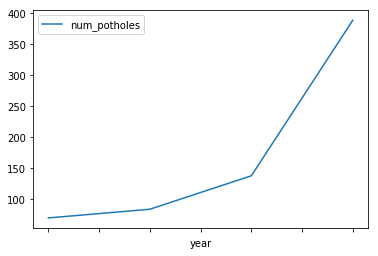

In [20]:
# select data for north oakland

request_type = "Potholes"
neighborhood = "North Oakland"

# Use Python 3.7 format strings
query = f'''
SELECT neighborhood, count(request_type) AS num_potholes, substr(created_on, 0, 5) AS year
FROM requests
WHERE request_type = '{request_type}' AND neighborhood = '{neighborhood}'
GROUP BY neighborhood, year
ORDER BY year ASC
LIMIT 20;
'''
print(query)

df = pd.read_sql(query, conn, index_col='year',parse_dates=True)

df.plot();